# Statistical analysis of data

## Project description
As an analyst for the company "Megaline" - a federal mobile operator, it is necessary to analyze the behavior of customers and make a conclusion - which tariff is better. Customers are offered two tariff plans: "Smart" and "Ultra". To adjust the advertising budget, the commercial department wants to understand which tariff brings more money. We have to do a preliminary analysis of tariffs on a small sample of customers. We have data on 500 Megaline users: who they are, where they are from, which tariff they use, how many calls and messages each sent in 2018. Tariff description.

Tariff description

Tariff "Smart":
* Monthly fee: 550 rubles.
* Included 500 minutes of talk, 50 messages and 15 GB of internet traffic.
* Cost of services beyond the tariff package: one minute of talk: 3 rubles, one message: 3 rubles, 1 GB of internet traffic: 200 rubles.

Tariff "Ultra":
* Monthly fee: 1950 rubles.
* Included 3000 minutes of talk, 1000 messages and 30 GB of internet traffic.
* Cost of services beyond the tariff package: one minute of talk: 1 ruble, one message: 1 ruble, 1 GB of internet traffic: 150 rubles.

## Note: 
"Megaline" always rounds seconds to minutes, and megabytes to gigabytes. Each call is rounded separately: even if it lasted only 1 second, it will be counted as 1 minute. For web traffic, individual sessions are not counted. Instead, the total amount for the month is rounded up. If the subscriber uses 1025 megabytes this month, they will be charged for 2 gigabytes. Please note that unused calls, SMS, and internet from the previous month are not carried over to the next month.

## Contents:

1. Data Overview.

2. Data Preparation.

3. Data Analysis.

4. Hypothesis Testing.

5. Conclusion.

## Description of data:
Table users (information about users):
* user_id - unique identifier of the user
* first_name - user's first name
* last_name - user's last name
* age - user's age (in years)
* reg_date - date of tariff connection (day, month, year)
* churn_date - date of tariff termination (if value is missing, then tariff was still active at the time of data extraction)
* city - city of residence of the user
* tariff - name of the tariff plan

Table calls (information about calls):
* id - unique number of the call
* call_date - date of the call
* duration - duration of the call in minutes
* user_id - identifier of the user who made the call

Table messages (information about messages):
* id - unique number of the message
* message_date - date of the message
* user_id - identifier of the user who sent the message

Table internet (information about internet sessions):
* id - unique number of the session
* mb_used - amount of internet traffic spent during the session (in megabytes)
* session_date - date of the internet session
* user_id - identifier of the user

Table tariffs (information about tariffs):
* tariff_name - name of the tariff
* rub_monthly_fee - monthly subscription fee in rubles
* minutes_included - number of minutes of conversation per month included in the subscription fee
* messages_included - number of messages per month included in the subscription fee
* mb_per_month_included - amount of internet traffic included in the subscription fee (in megabytes)
* rub_per_minute - cost of a minute of conversation beyond the tariff package (e.g. if the tariff includes 100 minutes of conversation per month, then from the 101st minute a fee will be charged)
* rub_per_message - cost of sending a message beyond the tariff package
* rub_per_gb - cost of an additional gigabyte of internet traffic beyond the tariff package (1 gigabyte = 1024 megabytes)

Note. If merging tables with the merge command leads to a dead kernell error, use join.

## 1. Data Overview

In [337]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
from functools import reduce
from scipy import stats as st

In [338]:
pd.set_option('display.max_columns', 50)

In [339]:
calls = pd.read_csv('https://code.s3.yandex.net/datasets/calls.csv')
internet = pd.read_csv('https://code.s3.yandex.net/datasets/internet.csv')
messages = pd.read_csv('https://code.s3.yandex.net/datasets/messages.csv')
tariffs = pd.read_csv('https://code.s3.yandex.net/datasets/tariffs.csv')
users = pd.read_csv('https://code.s3.yandex.net/datasets/users.csv')

In [340]:
calls.head(20)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


In [341]:
calls.info()
calls.describe().round(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,duration,user_id
count,202607.00,202607.00
mean,6.76,1253.94
std,5.84,144.72
min,0.00,1000.00
25%,1.30,1126.00
50%,6.00,1260.00
75%,10.70,1379.00
max,38.00,1499.00


Upon preliminary examination of the data, we can see that the calls dataframe has 202607 rows, no missing values, an average call duration of almost 7 minutes, and a median value of 6 minutes. The call duration ranges from 0 to 38 minutes.

In [342]:
internet.head(5)

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [343]:
internet.info()
internet.describe().round(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


,Unnamed: 0,mb_used,user_id
count,149396.00,149396.00,149396.00
mean,74697.50,370.19,1252.10
std,43127.05,278.30,144.05
min,0.00,0.00,1000.00
25%,37348.75,138.19,1130.00
50%,74697.50,348.02,1251.00
75%,112046.25,559.55,1380.00
max,149395.00,1724.83,1499.00


Upon preliminary examination of the data, we can see that the internet dataframe has 149395 rows, no missing values, a column called Unnamed: 0 with data that duplicates the dataframe indexing, an average internet traffic usage per session of almost 370 MB, and a median value of 348 MB. Internet traffic usage per session ranges from 0 to 1725 MB.

In [344]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [345]:
messages.info()
messages.describe().round(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,user_id
count,123036.00
mean,1256.99
std,143.52
min,1000.00
25%,1134.00
50%,1271.00
75%,1381.00
max,1499.00


Upon preliminary examination of the data, we can see that the messages dataframe has 123036 rows, and no missing values.

In [346]:
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [347]:
tariffs.info()
tariffs.describe().round(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
count,2.00,2.00,2.00,2.00,2.00,2.00,2.00
mean,525.00,23040.00,1750.00,1250.00,175.00,2.00,2.00
std,671.75,10861.16,1767.77,989.95,35.36,1.41,1.41
min,50.00,15360.00,500.00,550.00,150.00,1.00,1.00
25%,287.50,19200.00,1125.00,900.00,162.50,1.50,1.50
50%,525.00,23040.00,1750.00,1250.00,175.00,2.00,2.00
75%,762.50,26880.00,2375.00,1600.00,187.50,2.50,2.50
max,1000.00,30720.00,3000.00,1950.00,200.00,3.00,3.00


In [348]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [349]:
users.tail()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
495,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,NaN,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,NaN,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart
499,1499,35,NaN,Пермь,Гектор,Корнилов,2018-09-27,smart


In [350]:
users.info()
users.describe().round(0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age
count,500.0,500.0
mean,1250.0,47.0
std,144.0,17.0
min,1000.0,18.0
25%,1125.0,32.0
50%,1250.0,46.0
75%,1374.0,62.0
max,1499.0,75.0


In [351]:
print('The number of unique users:', users['user_id'].count())
print('The number of duplicates:', users.duplicated().sum())

The number of unique users: 500
The number of duplicates: 0


Upon preliminary examination of the data, we can see that the users dataframe has 500 rows, and missing values are present in the churn_date column. The average age of subscribers is 47 years, with a median of 46. The age range is from 18 to 75 years. The values are unique with no duplicates.

A preliminary review showed good data condition. 
* No missing values or values of clearly erroneous origin were found. 
* Missing values in the users dataframe in the churn_date column were identified; these missing values are present due to the fact that the data subscribers were still using the current tariff at the time of the download. Replacement or deletion of the missing values is not required. 
* In the internet dataframe, a column Unnamed: 0 was identified, which duplicates the dataframe indexing and is clearly of erroneous origin; this column must be deleted from the dataframe. 
* It is necessary to convert the data with dates to the datetime format.

## 2. Data Preparation.

### 2.1. Preparing data and transforming formats.

We will transform dates into the datetime format.

In [352]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')

We will delete the erroneous column from the internet dataframe.

In [353]:
internet = internet.drop('Unnamed: 0', 1)

<ipython-input-353-dab1720c4692>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  internet = internet.drop('Unnamed: 0', 1)


According to the conditions of "Megaline", seconds are always rounded to minutes and megabytes to gigabytes. Each call is rounded separately: even if it lasted only 1 second, it will be counted as 1 minute. We will round the duration of all calls and the used internet traffic volume to the nearest whole in the larger direction.

In [354]:
calls['duration'] = np.ceil(calls['duration'])
#internet['mb_used'] = np.ceil(internet['mb_used'])

Zero internet sessions: 0.13 %


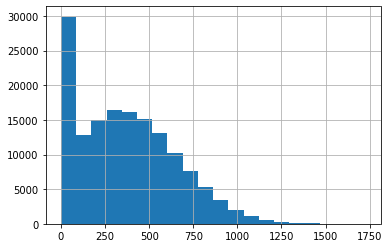

In [355]:
temp = internet.copy()
temp['mb_used'].hist(bins = 20)
print('Zero internet sessions:',round(temp['mb_used'].value_counts().sort_index()[0]/temp['mb_used'].count(),2), '%')

The table contains a session identifier and a user identifier. This means that the user established a connection and logged in. But the traffic is zero. And this is an anomaly, possibly related to technical problems of the operator. In this project, zero sessions do not interfere, but in the research outputs we will indicate this fact, as it is not the operator's revenue obtained with the existing demand for the user's service.

### 2.2. Calculated for each user.

We will add a column to each dataframe indicating the month of each iteration.

In [356]:
messages['month'] = messages['message_date'].dt.month
internet['month'] = internet['session_date'].dt.month
calls['month'] = calls['call_date'].dt.month

We will calculate the number of calls made and minutes of conversation per month.

In [357]:
calls_in_month = calls.pivot_table(
    index=['user_id', 'month'],
    values='duration',
    aggfunc=['count', 'sum']
)
calls_in_month.columns = ['calls', 'duration']

In [358]:
calls_in_month

calls  duration
user_id month                 
1000    5         22     159.0
        6         43     172.0
        7         47     340.0
        8         52     408.0
        9         58     466.0
...              ...       ...
1498    10        41     247.0
1499    9          9      70.0
        10        68     449.0
        11        74     612.0
        12        69     492.0

[3174 rows x 2 columns]

We will calculate the number of messages sent per month.

In [359]:
messages_in_month = messages.pivot_table(
    index=['user_id', 'month'],
    values='id',
    aggfunc='count'
)
messages_in_month.columns = ['num_messages']

In [360]:
messages_in_month

num_messages
user_id month              
1000    5                22
        6                60
        7                75
        8                81
        9                57
...                     ...
1498    10               42
1499    9                11
        10               48
        11               59
        12               66

[2717 rows x 1 columns]

We will calculate the amount of internet traffic consumed per month.

In [361]:
internet_in_month = internet.pivot_table(
    index=['user_id', 'month'],
    values='mb_used',
    aggfunc='sum'
)
internet_in_month.columns = ['mb']

In [362]:
internet_in_month

mb
user_id month          
1000    5       2253.49
        6      23233.77
        7      14003.64
        8      14055.93
        9      14568.91
...                 ...
1498    10     20579.36
1499    9       1845.75
        10     17788.51
        11     17963.31
        12     13055.58

[3203 rows x 1 columns]

For further analysis, we will create a summary dataframe.

In [363]:
calls_in_month

calls  duration
user_id month                 
1000    5         22     159.0
        6         43     172.0
        7         47     340.0
        8         52     408.0
        9         58     466.0
...              ...       ...
1498    10        41     247.0
1499    9          9      70.0
        10        68     449.0
        11        74     612.0
        12        69     492.0

[3174 rows x 2 columns]

In [364]:
df_users = calls_in_month.merge(messages_in_month, 
                                on=['user_id', 'month'], 
                                how='outer')

df_users = df_users.merge(internet_in_month, 
                          on=['user_id', 'month'], 
                          how='outer')

df_users = df_users.reset_index(drop=False)

df_users = df_users.merge(users[['user_id', 'tariff', 'city']], 
                          on='user_id', 
                          how='left')

In [365]:
df_users

,user_id,month,calls,duration,num_messages,mb,tariff,city
0,1000,5,22.0,159.0,22.0,2253.49,ultra,Краснодар
1,1000,6,43.0,172.0,60.0,23233.77,ultra,Краснодар
2,1000,7,47.0,340.0,75.0,14003.64,ultra,Краснодар
3,1000,8,52.0,408.0,81.0,14055.93,ultra,Краснодар
4,1000,9,58.0,466.0,57.0,14568.91,ultra,Краснодар
...,...,...,...,...,...,...,...,...
3209,1489,9,NaN,NaN,32.0,17206.30,smart,Санкт-Петербург
3210,1489,10,NaN,NaN,21.0,19559.44,smart,Санкт-Петербург
3211,1489,11,NaN,NaN,20.0,17491.56,smart,Санкт-Петербург
3212,1489,12,NaN,NaN,35.0,17322.51,smart,Санкт-Петербург


We will check if there are users who do not call, do not send SMS, and do not use the internet at the same time.

In [366]:
df_users[(df_users['mb'].isnull()) &
         (df_users['num_messages'].isnull()) & 
         (df_users['duration'].isnull())]

,user_id,month,calls,duration,num_messages,mb,tariff,city


In [367]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   user_id       3214 non-null   int64  
 1   month         3214 non-null   int64  
 2   calls         3174 non-null   float64
 3   duration      3174 non-null   float64
 4   num_messages  2717 non-null   float64
 5   mb            3203 non-null   float64
 6   tariff        3214 non-null   object 
 7   city          3214 non-null   object 
dtypes: float64(4), int64(2), object(2)
memory usage: 226.0+ KB


In [368]:
len(df_users.user_id.unique())

498

In [369]:
temp = users.copy()
temp[(temp.user_id ==  1128) | (temp.user_id ==  1371)]

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
128,1128,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra
371,1371,50,2018-12-30,Омск,Ириней,Трофимов,2018-12-25,smart


As seen when combining into the overall dataframe df_users due to the different amount of unique user_ids, the overall amount of unique users decreased from 500 to 498, a non-critical loss of data of 0.4%. Additionally, we should note that not all customers use all three services. The two customers that left after 5 and 8 days respectively should be noted in the conclusion, as this information will be useful for the commercial department to determine the reasons for customer departure.

We will replace the missing values with 0.

In [370]:
df_users = df_users.fillna(0)

In [371]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   user_id       3214 non-null   int64  
 1   month         3214 non-null   int64  
 2   calls         3214 non-null   float64
 3   duration      3214 non-null   float64
 4   num_messages  3214 non-null   float64
 5   mb            3214 non-null   float64
 6   tariff        3214 non-null   object 
 7   city          3214 non-null   object 
dtypes: float64(4), int64(2), object(2)
memory usage: 226.0+ KB


According to the tariff, traffic is calculated in gigabytes, we will convert monthly traffic to gigabytes.

In [372]:
df_users['gigabyte'] = df_users['mb'] / 1024

The operator takes into account the total monthly traffic in gigabytes, which is measured in megabytes and then rounded to the nearest whole number.

In [373]:
df_users['gigabyte'] = np.ceil(df_users['gigabyte'])

#### Let's calculate the monthly revenue from each user.

To calculate the monthly revenue, we will add additional columns.

In [374]:
month_price = {'smart': 550, 'ultra': 1950}
df_users['monthly_fee'] = df_users['tariff'].map(month_price).astype('float')

To add columns with information about used minutes, SMS, megabytes, and overpayment of the monthly tariff, we will write a function.

In [375]:
def calls_over_plan(row):
    if row['tariff'] == 'smart':
        result = row['duration'] - 500
        return np.where(result > 0, result, 0)
    else:
        result = row['duration'] - 3000
        return np.where(result > 0, result, 0)
    
    
def sms_over_plan(row):
    if row['tariff'] == 'smart':
        result = row['num_messages'] - 50
        return np.where(result > 0, result, 0)
    else:
        result =  row['num_messages'] - 1000
        return np.where(result > 0, result, 0)
    

def internet_over_plan(row):
    if row['tariff'] == 'smart':
        result = row['gigabyte'] - 15
        return np.where(result > 0, result, 0)
    else:
        result = row['gigabyte'] - 30
        return np.where(result > 0, result, 0)
    
    
def month_revenue(row):
    sum_per_month = 0
    if row['tariff'] == 'smart':
        sum_per_month += row['min_over_lim'] * 3
        sum_per_month += row['sms_over_lim'] * 3
        sum_per_month += row['gb_over_lim'] * 200
        return sum_per_month
    
    else:
        sum_per_month += row['min_over_lim'] * 1
        sum_per_month += row['sms_over_lim'] * 1
        sum_per_month += row['gb_over_lim'] * 150
        return sum_per_month

We will create the columns necessary for calculating the monthly revenue.

In [376]:
df_users['min_over_lim'] = df_users.apply(calls_over_plan, axis=1)
df_users['sms_over_lim'] = df_users.apply(sms_over_plan, axis=1)
df_users['gb_over_lim'] = df_users.apply(internet_over_plan, axis=1)
df_users['pay_over_lim'] = df_users.apply(month_revenue, axis=1)

In [377]:
for column in ['min_over_lim', 'gb_over_lim', 'sms_over_lim', 'pay_over_lim']:
    df_users[column] = df_users[column].astype('float')

In [378]:
df_users

,user_id,month,calls,duration,num_messages,mb,tariff,city,gigabyte,monthly_fee,min_over_lim,sms_over_lim,gb_over_lim,pay_over_lim
0,1000,5,22.0,159.0,22.0,2253.49,ultra,Краснодар,3.0,1950.0,0.0,0.0,0.0,0.0
1,1000,6,43.0,172.0,60.0,23233.77,ultra,Краснодар,23.0,1950.0,0.0,0.0,0.0,0.0
2,1000,7,47.0,340.0,75.0,14003.64,ultra,Краснодар,14.0,1950.0,0.0,0.0,0.0,0.0
3,1000,8,52.0,408.0,81.0,14055.93,ultra,Краснодар,14.0,1950.0,0.0,0.0,0.0,0.0
4,1000,9,58.0,466.0,57.0,14568.91,ultra,Краснодар,15.0,1950.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1489,9,0.0,0.0,32.0,17206.30,smart,Санкт-Петербург,17.0,550.0,0.0,0.0,2.0,400.0
3210,1489,10,0.0,0.0,21.0,19559.44,smart,Санкт-Петербург,20.0,550.0,0.0,0.0,5.0,1000.0
3211,1489,11,0.0,0.0,20.0,17491.56,smart,Санкт-Петербург,18.0,550.0,0.0,0.0,3.0,600.0
3212,1489,12,0.0,0.0,35.0,17322.51,smart,Санкт-Петербург,17.0,550.0,0.0,0.0,2.0,400.0


To create a column for monthly revenue, we will sum the data in the monthly_fee and pay_over_lim columns line by line.

In [379]:
df_users['month_revenue'] = df_users['monthly_fee'] + df_users['pay_over_lim']

In [380]:
df_users.head()

,user_id,month,calls,duration,num_messages,mb,tariff,city,gigabyte,monthly_fee,min_over_lim,sms_over_lim,gb_over_lim,pay_over_lim,month_revenue
0,1000,5,22.0,159.0,22.0,2253.49,ultra,Краснодар,3.0,1950.0,0.0,0.0,0.0,0.0,1950.0
1,1000,6,43.0,172.0,60.0,23233.77,ultra,Краснодар,23.0,1950.0,0.0,0.0,0.0,0.0,1950.0
2,1000,7,47.0,340.0,75.0,14003.64,ultra,Краснодар,14.0,1950.0,0.0,0.0,0.0,0.0,1950.0
3,1000,8,52.0,408.0,81.0,14055.93,ultra,Краснодар,14.0,1950.0,0.0,0.0,0.0,0.0,1950.0
4,1000,9,58.0,466.0,57.0,14568.91,ultra,Краснодар,15.0,1950.0,0.0,0.0,0.0,0.0,1950.0


## 3. Data Analysis.

Let's calculate how many minutes of conversation, messages, and internet traffic each tariff user requires per month.

In [381]:
average_demand = df_users.pivot_table(index='user_id', 
                                      values=['duration', 'num_messages', 'gigabyte', 'month_revenue', 'tariff'], 
                                      aggfunc='median')

average_demand = average_demand.merge(users[['user_id', 'tariff',]], 
                                      on='user_id', 
                                      how='left')
average_demand.describe().round()

,user_id,duration,gigabyte,month_revenue,num_messages
count,498.0,498.0,498.0,498.0,498.0
mean,1250.0,473.0,18.0,1529.0,41.0
std,145.0,220.0,6.0,716.0,37.0
min,1000.0,0.0,0.0,550.0,0.0
25%,1124.0,325.0,14.0,891.0,12.0
50%,1250.0,462.0,18.0,1550.0,32.0
75%,1375.0,591.0,21.0,1950.0,60.0
max,1499.0,1273.0,39.0,5680.0,197.0


Let's calculate the average, variance, and standard deviation.

To calculate the "outliers" we will write a function.

In [382]:
def span_charts(column):
    stat = average_demand[column].describe()
    quantile = stat[6] - stat[4]     
    left_mustache = round(stat[4] - 1.5 * quantile, 2)
    right_mustache = round(stat[6] + 1.5 * quantile, 2)
    if left_mustache < stat[3]:
        left_mustache = stat[3] 
    if right_mustache > stat[7]:
        right_mustache = stat[7]
        
    return [left_mustache, right_mustache]

#### Calls:

In [383]:
tariff_smart = average_demand.query('tariff == "smart"')
tariff_ultra = average_demand.query('tariff == "ultra"')

tariff_smart_mean_call = tariff_smart['duration'].mean()#.round(2)
tariff_smart_var_call = np.var(tariff_smart['duration'], ddof=1)#.round(2)
tariff_smart_std_call = np.std(tariff_smart['duration'], ddof=1)#.round(2)
tariff_ultra_mean_call = tariff_ultra['duration'].mean()#.round(2)
tariff_ultra_var_call = np.var(tariff_ultra['duration'], ddof=1)#.round(2)
tariff_ultra_std_call = np.std(tariff_ultra['duration'], ddof=1)#.round(2)

In [384]:
print('The average number of minutes on Smart:', tariff_smart_mean_call)
print('The variance on Smart:', tariff_smart_var_call)
print('The standard deviation on Smart:', tariff_smart_std_call)
print('The data on Smart lies within the range:', tariff_smart_mean_call - 3 * tariff_smart_std_call,' and ',tariff_smart_mean_call + 3 * tariff_smart_std_call)
print('')
print('The average number of minutes on Ultra:', tariff_ultra_mean_call)
print('The variance on Ultra:', tariff_ultra_var_call)
print('The standard deviation on Ultra:', tariff_ultra_std_call)
print('The data on Ultra lies within the range:', tariff_ultra_mean_call - 3 * tariff_ultra_std_call,' and ',tariff_ultra_mean_call + 3 * tariff_ultra_std_call)
print('')
print('Outliers:', span_charts('duration'))

The average number of minutes on Smart: 437.4685714285714
The variance on Smart: 25685.390126893162
The standard deviation on Smart: 160.26662199875918
The data on Smart lies within the range: -43.331294567706095  and  918.2684374248489

The average number of minutes on Ultra: 557.5033783783783
The variance on Ultra: 92290.57651912117
The standard deviation on Ultra: 303.7936413408305
The data on Ultra lies within the range: -353.8775456441132  and  1468.8843024008697

Outliers: [0.0, 990.56]


(0.0, 990.0)

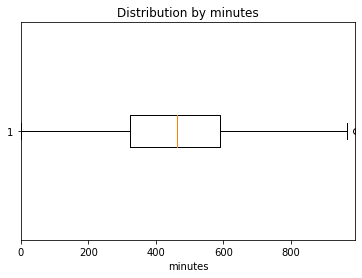

In [385]:
plt.boxplot(average_demand['duration'], vert=False)
plt.title('Distribution by minutes')
plt.xlabel('minutes')
plt.xlim(0, 990)

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


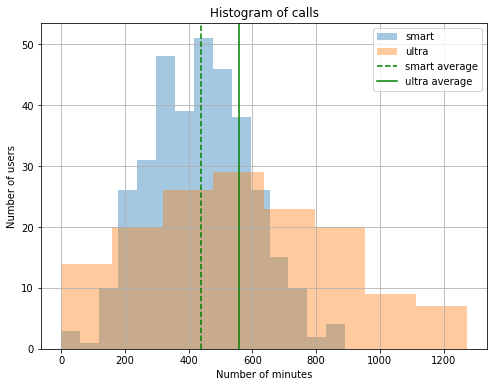

In [386]:
plt.figure(figsize=(8, 6))
sb.distplot(tariff_smart['duration'], kde=False, label='smart')
sb.distplot(tariff_ultra['duration'], kde=False, label='ultra')
plt.axvline(np.mean(tariff_smart['duration']),
            color='g', 
            linestyle='--', 
            label='smart average')
plt.axvline(np.mean(tariff_ultra['duration']),
            color='g', 
            linestyle='-', 
            label='ultra average')
plt.legend()
plt.xlabel('Number of minutes')
plt.ylabel('Number of users')
plt.title('Histogram of calls')
plt.grid(True)

#### SMS:

In [387]:
tariff_smart_mean_sms = tariff_smart['num_messages'].mean()#.round(2)
tariff_smart_var_sms = np.var(tariff_smart['num_messages'], ddof=1)#.round(2)
tariff_smart_std_sms = np.std(tariff_smart['num_messages'], ddof=1)#.round(2)
tariff_ultra_mean_sms = tariff_ultra['num_messages'].mean()#.round(2)
tariff_ultra_var_sms = np.var(tariff_ultra['num_messages'], ddof=1)#.round(2)
tariff_ultra_std_sms = np.std(tariff_ultra['num_messages'], ddof=1)#.round(2)

In [388]:
print('The average number of sms on Smart:', tariff_smart_mean_sms)
print('The variance on Smart:', tariff_smart_var_sms)
print('The standard deviation on Smart:', tariff_smart_std_sms)
print('The data on Smart lies within the range:', tariff_smart_mean_sms - 3 * tariff_smart_std_sms,' и ',tariff_smart_mean_sms + 3 * tariff_smart_std_sms)
print('')
print('The average number of sms on Ultra:', tariff_ultra_mean_sms)
print('The variance on Ultra:', tariff_ultra_var_sms)
print('The standard deviation on Ultra:', tariff_ultra_std_sms)
print('The data on Ultra lies within the range:', tariff_ultra_mean_sms - 3 * tariff_ultra_std_sms,' и ',tariff_ultra_mean_sms + 3 * tariff_ultra_std_sms)
print('')
print('Outliers:', span_charts('num_messages'))

The average number of sms on Smart: 33.77
The variance on Smart: 784.5966618911175
The standard deviation on Smart: 28.010652650217157
The data on Smart lies within the range: -50.26195795065147  и  117.80195795065148

The average number of sms on Ultra: 56.983108108108105
The variance on Ultra: 2424.263318165104
The standard deviation on Ultra: 49.23680857006376
The data on Ultra lies within the range: -90.72731760208316  и  204.69353381829936

Outliers: [0.0, 132.0]


(0.0, 132.0)

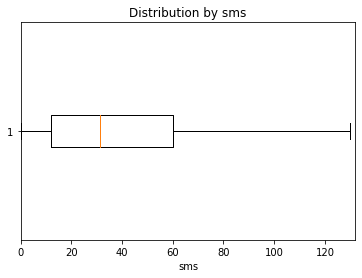

In [389]:
plt.boxplot(average_demand['num_messages'], vert=False)
plt.title('Distribution by sms')
plt.xlabel('sms')
plt.xlim(0, 132)

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


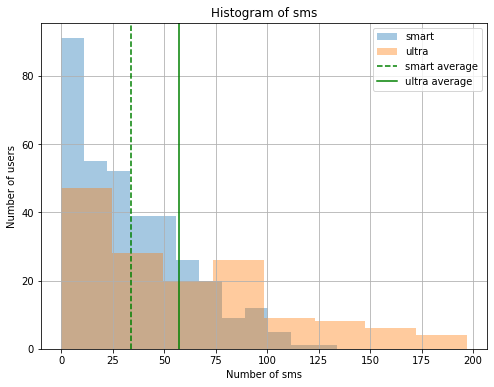

In [390]:
plt.figure(figsize=(8, 6))
sb.distplot(tariff_smart['num_messages'], kde=False, label='smart')
sb.distplot(tariff_ultra['num_messages'], kde=False, label='ultra')
plt.axvline(np.mean(tariff_smart['num_messages']),
            color='g', 
            linestyle='--', 
            label='smart average')
plt.axvline(np.mean(tariff_ultra['num_messages']),
            color='g', 
            linestyle='-', 
            label='ultra average')
plt.legend()
plt.xlabel('Number of sms')
plt.ylabel('Number of users')
plt.title('Histogram of sms')
plt.grid(True)

##### Traffic:

In [391]:
tariff_smart_mean_gb = tariff_smart['gigabyte'].mean()#.round(2)
tariff_smart_var_gb = np.var(tariff_smart['gigabyte'], ddof=1)#.round(2)
tariff_smart_std_gb = np.std(tariff_smart['gigabyte'], ddof=1)#.round(2)
tariff_ultra_mean_gb = tariff_ultra['gigabyte'].mean()#.round(2)
tariff_ultra_var_gb = np.var(tariff_ultra['gigabyte'], ddof=1)#.round(2)
tariff_ultra_std_gb = np.std(tariff_ultra['gigabyte'], ddof=1)#.round(2)

In [392]:
print('The average number of Gb on Smart:', tariff_smart_mean_gb)
print('The variance on Smart:', tariff_smart_var_gb)
print('The standard deviation on Smart:', tariff_smart_std_gb)
print('The data on Smart lies within the range:', tariff_smart_mean_gb - 3 * tariff_smart_std_gb,' and ',tariff_smart_mean_gb + 3 * tariff_smart_std_gb)
print('')
print('The average number of Gb on Ultra:', tariff_ultra_mean_gb)
print('The variance on Ultra:', tariff_ultra_var_gb)
print('The standard deviation on Ultra:', tariff_ultra_std_gb)
print('The data on Ultra lies within the range:', tariff_ultra_mean_gb - 3 * tariff_ultra_std_gb,' and ',tariff_ultra_mean_gb + 3 * tariff_ultra_std_gb)
print('')
print('Outliers:', span_charts('gigabyte'))

The average number of Gb on Smart: 16.927142857142858
The variance on Smart: 16.56845886205485
The standard deviation on Smart: 4.07043718316041
The data on Smart lies within the range: 4.715831307661629  and  29.138454406624085

The average number of Gb on Ultra: 20.31756756756757
The variance on Ultra: 75.84064166207024
The standard deviation on Ultra: 8.708653263396714
The data on Ultra lies within the range: -5.808392222622576  and  46.443527357757716

Outliers: [3.5, 31.5]


(3.5, 31.5)

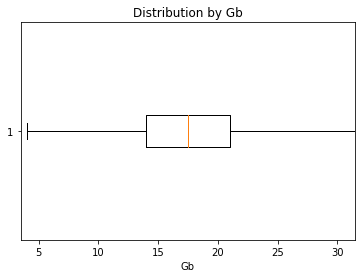

In [393]:
plt.boxplot(average_demand['gigabyte'], vert=False)
plt.title('Distribution by Gb')
plt.xlabel('Gb')
plt.xlim(3.5, 31.5)

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


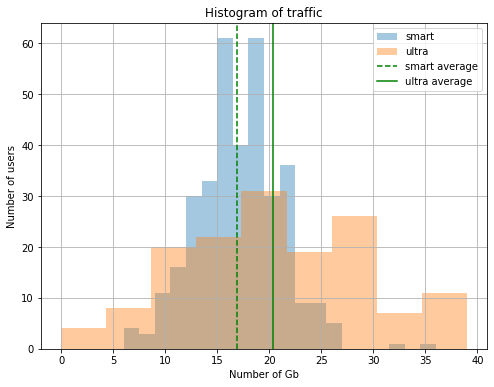

In [394]:
plt.figure(figsize=(8, 6))
sb.distplot(tariff_smart['gigabyte'], kde=False, label='smart')
sb.distplot(tariff_ultra['gigabyte'], kde=False, label='ultra')
plt.axvline(np.mean(tariff_smart['gigabyte']),
            color='g', 
            linestyle='--', 
            label='smart average')
plt.axvline(np.mean(tariff_ultra['gigabyte']),
            color='g', 
            linestyle='-', 
            label='ultra average')
plt.legend()
plt.xlabel('Number of Gb')
plt.ylabel('Number of users')
plt.title('Histogram of traffic')
plt.grid(True)

We will additionally calculate a table with data on subscribers' overconsumption of service packages.

In [395]:
users['tariff'].value_counts()

smart    351
ultra    149
Name: tariff, dtype: int64

As can be seen, there are 2.35 more Smart users than Ultra subscribers.

Average consumption by tariffs.

In [396]:
tariff_consumption = average_demand.pivot_table(index='tariff', values=['duration', 'gigabyte', 'num_messages', 'month_revenue'])
tariff_consumption['monthly_fee'] = [550, 1950]
tariff_consumption = tariff_consumption.reset_index(drop=False).round()
tariff_consumption['overpayment_perc'] = ((tariff_consumption['month_revenue'] / tariff_consumption['monthly_fee']) - 1)*100
tariff_consumption['overpayment'] = (tariff_consumption['month_revenue'] - tariff_consumption['monthly_fee'])
tariff_consumption['dev_duration'] = 0
tariff_consumption['dev_sms'] = 0
tariff_consumption['dev_gb'] = 0
tariff_consumption.loc[tariff_consumption['tariff'] == 'smart', 'dev_duration'] = (tariff_consumption['duration'] - 500)
tariff_consumption.loc[tariff_consumption['tariff'] == 'ultra', 'dev_duration'] = (tariff_consumption['duration'] - 3000)

tariff_consumption.loc[tariff_consumption['tariff'] == 'smart', 'dev_sms'] = (tariff_consumption['num_messages'] - 50)
tariff_consumption.loc[tariff_consumption['tariff'] == 'ultra', 'dev_sms'] = (tariff_consumption['num_messages'] - 1000)

tariff_consumption.loc[tariff_consumption['tariff'] == 'smart', 'dev_gb'] = (tariff_consumption['gigabyte'] - 15)
tariff_consumption.loc[tariff_consumption['tariff'] == 'ultra', 'dev_gb'] = (tariff_consumption['gigabyte'] - 30)

tariff_consumption['dev_duration_perc'] = 0
tariff_consumption['dev_sms_perc'] = 0
tariff_consumption['dev_gb_perc'] = 0

tariff_consumption.loc[tariff_consumption['tariff'] == 'smart', 'dev_duration_perc'] = (tariff_consumption['duration'] / 500) * 100
tariff_consumption.loc[tariff_consumption['tariff'] == 'ultra', 'dev_duration_perc'] = (tariff_consumption['duration'] / 3000) * 100

tariff_consumption.loc[tariff_consumption['tariff'] == 'smart', 'dev_sms_perc'] = (tariff_consumption['num_messages'] / 50) * 100
tariff_consumption.loc[tariff_consumption['tariff'] == 'ultra', 'dev_sms_perc'] = (tariff_consumption['num_messages'] / 1000) * 100

tariff_consumption.loc[tariff_consumption['tariff'] == 'smart', 'dev_gb_perc'] = (tariff_consumption['gigabyte'] / 15) * 100
tariff_consumption.loc[tariff_consumption['tariff'] == 'ultra', 'dev_gb_perc'] = (tariff_consumption['gigabyte'] / 30) * 100

tariff_consumption = tariff_consumption.reindex(columns=['tariff', 'duration', 'dev_duration', 'dev_duration_perc', 'num_messages', 'dev_sms', 'dev_sms_perc','gigabyte', 'dev_gb', 'dev_gb_perc','monthly_fee', 'month_revenue', 'overpayment', 'overpayment_perc']).round(1)

In [397]:
tariff_consumption

,tariff,duration,dev_duration,dev_duration_perc,num_messages,dev_sms,dev_sms_perc,gigabyte,dev_gb,dev_gb_perc,monthly_fee,month_revenue,overpayment,overpayment_perc
0,smart,437.0,-63.0,87.4,34.0,-16.0,68.0,17.0,2.0,113.3,550,1304.0,754.0,137.1
1,ultra,558.0,-2442.0,18.6,57.0,-943.0,5.7,20.0,-10.0,66.7,1950,2061.0,111.0,5.7


- duration - Average number of minutes used for phone calls;
- dev_duration - Excess minutes relative to the tariff package;
- dev_duration_perc - % Usage of the tariff package;
- num_messages - Average number of SMS sent;
- dev_sms - Excess SMS relative to the tariff package;
- dev_sms_perc - % Usage of the tariff package;
- gigabyte - Average amount of internet traffic used;
- dev_gb - Excess traffic relative to the tariff package;
- dev_gb_perc - % Usage of the tariff package;
- monthly_fee - Subscription fee according to the tariff;
- month_revenue - Average monthly payment according to the tariff (monthly operator revenue);
- overpayment - Overpayment in rubles;
- overpayment_perc - Overpayment in %.

As we can see from the calculations, on average, users make more use of the tariff package limits. At the same time, as we can see, users of both tariff packages pay more than the subscription fee per month, with the Smart and Ultra tariffs overpaying by 137% and 5.7%, respectively, from the monthly subscription fee. Moreover, Smart tariff users clearly lack the basic internet traffic package and users clearly buy additional megabytes.

It is initially clear that Ultra tariff users are more active users and use the minutes, SMS and traffic packages in larger volumes than Smart users and, as can be seen from the data, to a greater extent do not use the tariff limits to the full extent than on Smart. This leads to the thought of a clear imbalance of tariffs and the routine work of the company's marketing.

Let's look at the territorial distribution of subscribers.

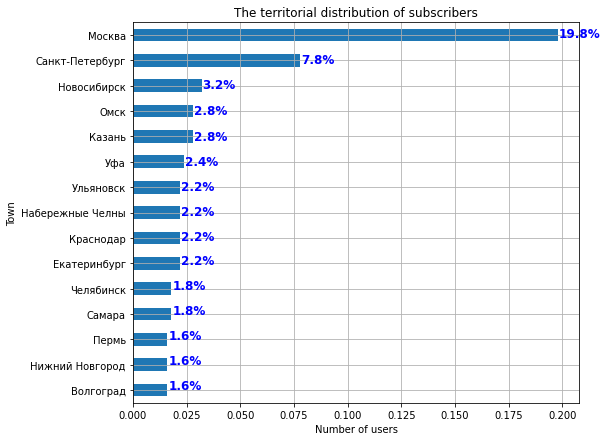

In [398]:
all_users = len(users)
df_for_barh = users.groupby('city').size()/all_users
df_for_barh_filtered = df_for_barh[df_for_barh > 0.015].sort_values()
ax = df_for_barh_filtered.plot(kind='barh', figsize=(8,7))

labels = dict(df_for_barh_filtered)
labels

i = 0
for city in labels:
    ax.text(labels[city] + 0.0005, i + 0.05, str(round(labels[city]*100, 2)) + '%', 
            fontsize = 'large', fontweight='bold', color='blue')
    if i < 9.7:
        i += 0.98
    else:
        i += 1.02

plt.title('The territorial distribution of subscribers')
plt.ylabel('Town')
plt.xlabel('Number of users')
plt.grid(True)
plt.show()

The main volume of subscribers is in Moscow with 19.8% of users and St. Petersburg with 7.8% respectively.

Let's look at the distribution of minutes, SMS and internet traffic consumed by subscribers per month.

 Distribution of the number of calls and call duration.

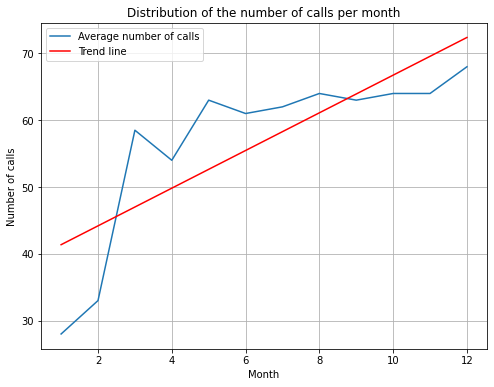

In [399]:
pivot_table_calls = df_users.pivot_table(index = 'month', 
                                         values = 'calls', 
                                         aggfunc = ['mean', 'count', 'median']
                                         ).reset_index()
                                         
pivot_table_calls.columns = ['month','mean', 'count', 'median']

x = pivot_table_calls['month']
y = pivot_table_calls['median']
plt.figure(figsize=(8, 6))
plt.plot(x, y)
plt.title('Distribution of the number of calls per month')
plt.ylabel('Number of calls')
plt.xlabel('Month')
plt.grid(True)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),'r')
plt.legend(['Average number of calls','Trend line'])
plt.show()

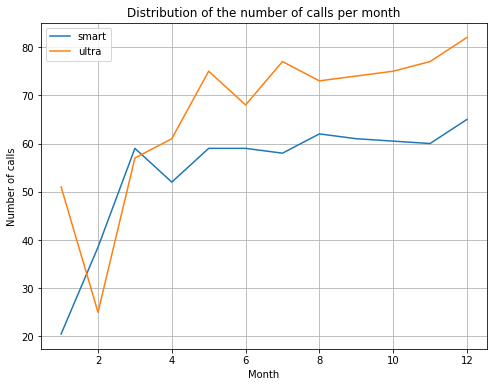

In [400]:
pivot_table_calls_smart = df_users.query('tariff == "smart"').pivot_table(index = 'month', 
                                                                          values = 'calls', 
                                                                          aggfunc = ['mean', 'count', 'median']
                                                                          ).reset_index()

pivot_table_calls_smart.columns = ['month','mean', 'count', 'median']

x = pivot_table_calls_smart['month']
y = pivot_table_calls_smart['median']

pivot_table_calls_ultra = df_users.query('tariff == "ultra"').pivot_table(index = 'month', 
                                                                          values = 'calls', 
                                                                          aggfunc = ['mean', 'count', 'median']
                                                                          ).reset_index()
                                                                          
pivot_table_calls_ultra.columns = ['month','mean', 'count', 'median']

a = pivot_table_calls_ultra['month']
b = pivot_table_calls_ultra['median']

plt.figure(figsize=(8, 6))
plt.plot(x, y)
plt.plot(a, b)
plt.title('Distribution of the number of calls per month')
plt.ylabel('Number of calls')
plt.xlabel('Month')
plt.grid(True)
plt.legend(['smart','ultra'])
plt.show()

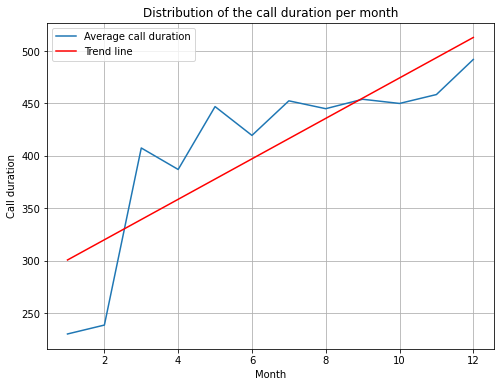

In [401]:
pivot_table_duration = df_users.pivot_table(index = 'month', 
                                            values = 'duration', 
                                            aggfunc = ['mean', 'count', 'median']
                                            ).reset_index()
                                            
pivot_table_duration.columns = ['month','mean', 'count', 'median']

x = pivot_table_duration['month']
y = pivot_table_duration['median']
plt.figure(figsize=(8, 6))
plt.plot(x, y)
plt.title('Distribution of the call duration per month')
plt.ylabel('Call duration')
plt.xlabel('Month')
plt.grid(True)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),'r')
plt.legend(['Average call duration','Trend line'])
plt.show()

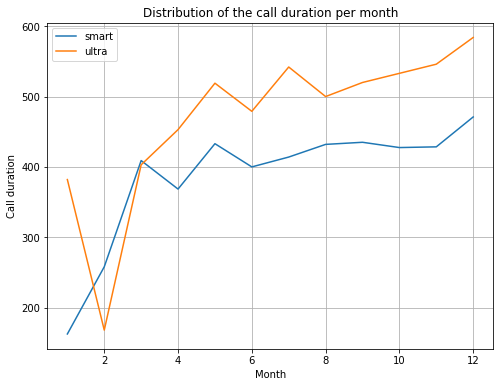

In [402]:
pivot_table_pivot_table_duration_smart = df_users.query('tariff == "smart"').pivot_table(index = 'month', 
                                                                                         values = 'duration',
                                                                                         aggfunc = ['mean', 'count', 'median']
                                                                                         ).reset_index()

pivot_table_pivot_table_duration_smart.columns = ['month','mean', 'count', 'median']

x = pivot_table_pivot_table_duration_smart['month']
y = pivot_table_pivot_table_duration_smart['median']

pivot_table_pivot_table_duration_ultra = df_users.query('tariff == "ultra"').pivot_table(index = 'month', 
                                                                                         values = 'duration', 
                                                                                         aggfunc = ['mean', 'count', 'median']
                                                                                         ).reset_index()
                                                                                         
pivot_table_pivot_table_duration_ultra.columns = ['month','mean', 'count', 'median']

a = pivot_table_pivot_table_duration_ultra['month']
b = pivot_table_pivot_table_duration_ultra['median']

plt.figure(figsize=(8, 6))
plt.plot(x, y)
plt.plot(a, b)
plt.title('Distribution of the call duration per month')
plt.ylabel('Call duration')
plt.xlabel('Month')
plt.grid(True)
plt.legend(['smart','ultra'])
plt.show()

Conclusion: We can see that the density and duration of calls towards the end of the year is increasing. Also, the duration and number of calls from Smart and Ultra subscribers is similar to the average distribution, but differs in volume from each other.

Distribution of the number of SMS sent.

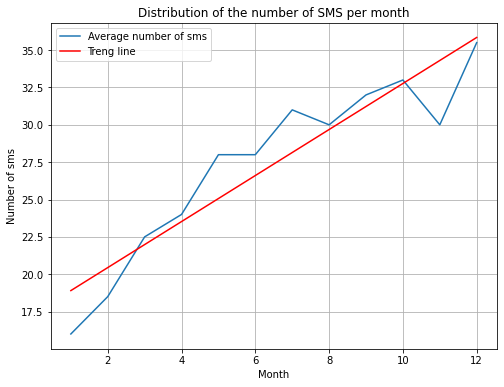

In [403]:
pivot_table_sms = df_users.pivot_table(index = 'month', 
                                       values = 'num_messages', 
                                       aggfunc = ['mean', 'count', 'median']
                                       ).reset_index()
                                       
pivot_table_sms.columns = ['month','mean', 'count', 'median']

x = pivot_table_sms['month']
y = pivot_table_sms['median']
plt.figure(figsize=(8, 6))
plt.plot(x, y)
plt.title('Distribution of the number of SMS per month')
plt.ylabel('Number of sms')
plt.xlabel('Month')
plt.grid(True)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),'r')
plt.legend(['Average number of sms','Treng line'])
plt.show()

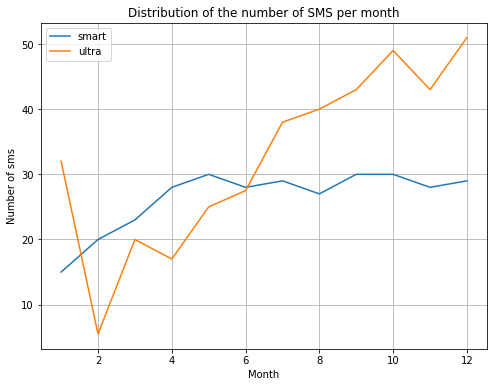

In [404]:
pivot_table_sms_smart = df_users.query('tariff == "smart"').pivot_table(index = 'month', 
                                                                        values = 'num_messages', 
                                                                        aggfunc = ['mean', 'count', 'median']
                                                                        ).reset_index()

pivot_table_sms_smart.columns = ['month','mean', 'count', 'median']

x = pivot_table_sms_smart['month']
y = pivot_table_sms_smart['median']

pivot_table_sms_ultra = df_users.query('tariff == "ultra"').pivot_table(index = 'month', 
                                                                        values = 'num_messages', 
                                                                        aggfunc = ['mean', 'count', 'median']
                                                                        ).reset_index()

pivot_table_sms_ultra.columns = ['month','mean', 'count', 'median']

a = pivot_table_sms_ultra['month']
b = pivot_table_sms_ultra['median']

plt.figure(figsize=(8, 6))
plt.plot(x, y)
plt.plot(a, b)
plt.title('Distribution of the number of SMS per month')
plt.ylabel('Number of sms')
plt.xlabel('Month')
plt.grid(True)
plt.legend(['smart','ultra'])
plt.show()

Conclusion: We can see that on average, the number of SMS sent increases by the end of the year. Also, Smart subscribers send SMS more evenly than Ultra subscribers. Also, it is not explicit, in my opinion, but Ultra subscribers have a seasonal pattern with an increase in the number of SMS from February to December and a sharp decrease in January. If this trend continues for several years, then such a product can be confidently classified as seasonal.

Distribution of consumed internet traffic.

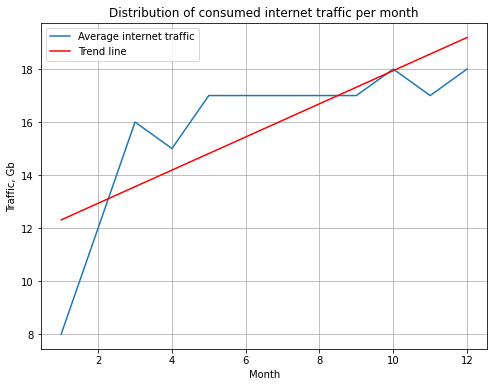

In [405]:
pivot_table_mb = df_users.pivot_table(index = 'month', 
                                      values = 'gigabyte', 
                                      aggfunc = ['mean', 'count', 'median']
                                      ).reset_index()
                                      
pivot_table_mb.columns = ['month','mean', 'count', 'median']

x = pivot_table_mb['month']
y = pivot_table_mb['median']
plt.figure(figsize=(8, 6))
plt.plot(x, y)
plt.title('Distribution of consumed internet traffic per month')
plt.ylabel('Traffic, Gb')
plt.xlabel('Month')
plt.grid(True)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),'r')
plt.legend(['Average internet traffic','Trend line'])
plt.show()

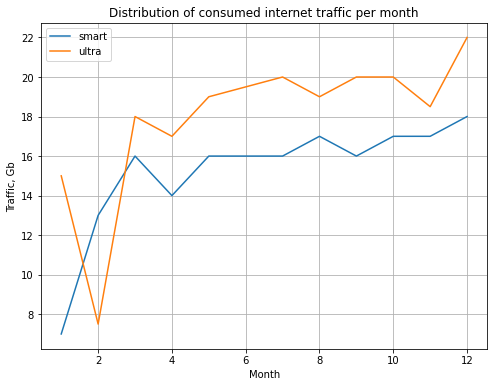

In [406]:
pivot_table_mb_smart = df_users.query('tariff == "smart"').pivot_table(index = 'month', 
                                                                       values = 'gigabyte', 
                                                                       aggfunc = ['mean', 'count', 'median']
                                                                       ).reset_index()
                                                                       
pivot_table_mb_smart.columns = ['month','mean', 'count', 'median']

x = pivot_table_mb_smart['month']
y = pivot_table_mb_smart['median']

pivot_table_mb_ultra = df_users.query('tariff == "ultra"').pivot_table(index = 'month', 
                                                                       values = 'gigabyte', 
                                                                       aggfunc = ['mean', 'count', 'median']
                                                                       ).reset_index()

pivot_table_mb_ultra.columns = ['month','mean', 'count', 'median']

a = pivot_table_mb_ultra['month']
b = pivot_table_mb_ultra['median']

plt.figure(figsize=(8, 6))
plt.plot(x, y)
plt.plot(a, b)
plt.title('Distribution of consumed internet traffic per month')
plt.ylabel('Traffic, Gb')
plt.xlabel('Month')
plt.grid(True)
plt.legend(['smart','ultra'])
plt.show()

Conclusion: We can see that the volume of internet traffic is increasing towards the end of the year. Also, the consumption of internet traffic of Smart and Ultra subscribers is similar to the average distribution, but differs in volume from each other.

Let's consider the distribution of minutes, SMS and internet traffic by cities.

In [407]:
df_users

,user_id,month,calls,duration,num_messages,mb,tariff,city,gigabyte,monthly_fee,min_over_lim,sms_over_lim,gb_over_lim,pay_over_lim,month_revenue
0,1000,5,22.0,159.0,22.0,2253.49,ultra,Краснодар,3.0,1950.0,0.0,0.0,0.0,0.0,1950.0
1,1000,6,43.0,172.0,60.0,23233.77,ultra,Краснодар,23.0,1950.0,0.0,0.0,0.0,0.0,1950.0
2,1000,7,47.0,340.0,75.0,14003.64,ultra,Краснодар,14.0,1950.0,0.0,0.0,0.0,0.0,1950.0
3,1000,8,52.0,408.0,81.0,14055.93,ultra,Краснодар,14.0,1950.0,0.0,0.0,0.0,0.0,1950.0
4,1000,9,58.0,466.0,57.0,14568.91,ultra,Краснодар,15.0,1950.0,0.0,0.0,0.0,0.0,1950.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1489,9,0.0,0.0,32.0,17206.30,smart,Санкт-Петербург,17.0,550.0,0.0,0.0,2.0,400.0,950.0
3210,1489,10,0.0,0.0,21.0,19559.44,smart,Санкт-Петербург,20.0,550.0,0.0,0.0,5.0,1000.0,1550.0
3211,1489,11,0.0,0.0,20.0,17491.56,smart,Санкт-Петербург,18.0,550.0,0.0,0.0,3.0,600.0,1150.0
3212,1489,12,0.0,0.0,35.0,17322.51,smart,Санкт-Петербург,17.0,550.0,0.0,0.0,2.0,400.0,950.0


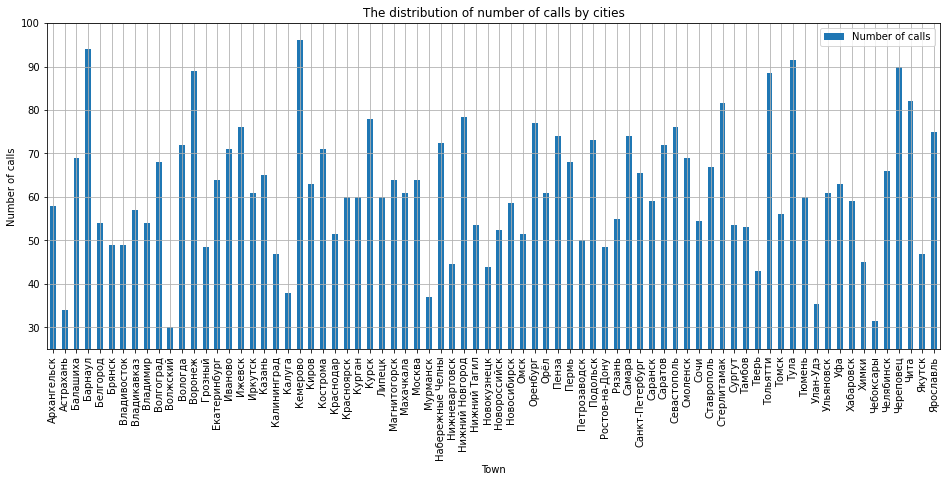

In [408]:
pivot_table_city_calls = df_users.pivot_table(index = 'city', 
                                              values = 'calls', 
                                              aggfunc = ['mean', 'count', 'median']
                                              ).sort_values('city')

pivot_table_city_calls.columns = ['mean', 'count', 'median']

pivot_table_city_calls.plot(y = 'median', 
                            figsize=(16, 6), 
                            kind='bar', 
                            rot=90)
plt.title('The distribution of number of calls by cities')
plt.ylabel('Number of calls')
plt.xlabel('Town')
plt.legend(['Number of calls'])
plt.ylim(25, 100)
plt.grid(True)

In [409]:
pivot_table_city_calls[pivot_table_city_calls['median']==pivot_table_city_calls['median'].max()]

,mean,count,median
city,,,
Кемерово,79.2,5,96.0


In [410]:
pivot_table_city_calls[pivot_table_city_calls['median']==pivot_table_city_calls['median'].min()]

,mean,count,median
city,,,
Волжский,30.0,7,30.0


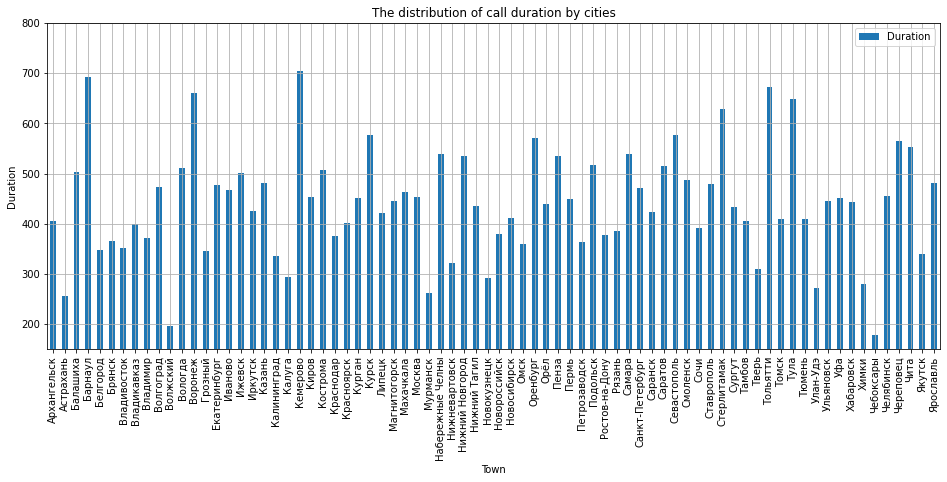

In [411]:
pivot_table_city_dur = df_users.pivot_table(index = 'city', 
                                            values = 'duration', 
                                            aggfunc = ['mean', 'count', 'median']
                                            ).sort_values('city')

pivot_table_city_dur.columns = ['mean', 'count', 'median']

pivot_table_city_dur.plot(y = 'median', 
                          figsize=(16, 6), 
                          kind='bar', 
                          rot=90)
plt.title('The distribution of call duration by cities')
plt.ylabel('Duration')
plt.xlabel('Town')
plt.legend(['Duration'])
plt.ylim(150, 800)
plt.grid(True)

In [412]:
pivot_table_city_dur[pivot_table_city_dur['median']==pivot_table_city_dur['median'].max()]

,mean,count,median
city,,,
Кемерово,579.0,5,705.0


In [413]:
pivot_table_city_dur[pivot_table_city_dur['median']==pivot_table_city_dur['median'].min()]

,mean,count,median
city,,,
Чебоксары,216.35,20,177.5


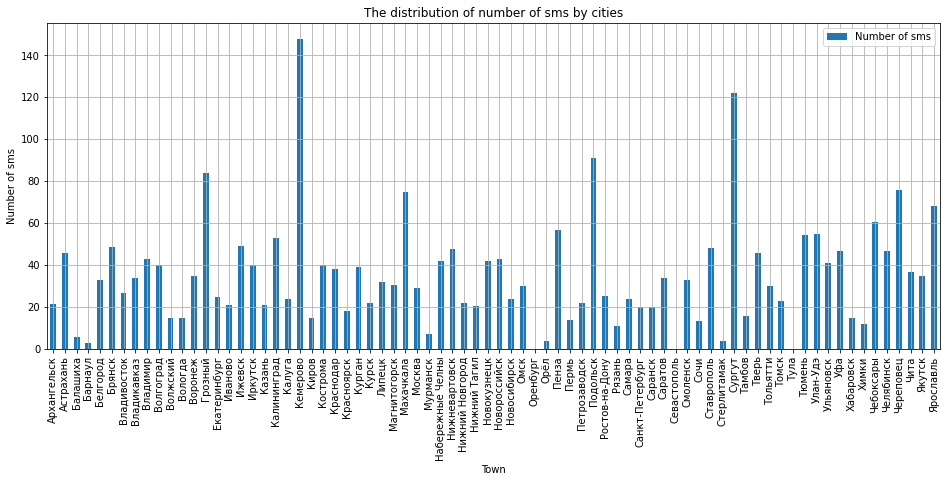

In [414]:
pivot_table_city_sms = df_users.pivot_table(index = 'city', 
                                            values = 'num_messages', 
                                            aggfunc = ['mean', 'count', 'median']
                                            ).sort_values('city')

pivot_table_city_sms.columns = ['mean', 'count', 'median']

pivot_table_city_sms.plot(y = 'median', 
                          figsize=(16, 6),
                          kind='bar', 
                          rot=90)
plt.title('The distribution of number of sms by cities')
plt.ylabel('Number of sms')
plt.xlabel('Town')
plt.legend(['Number of sms'])
plt.grid(True)

In [415]:
pivot_table_city_sms[pivot_table_city_sms['mean']==pivot_table_city_sms['mean'].max()]

,mean,count,median
city,,,
Сургут,110.833333,6,122.0


In [416]:
pivot_table_city_sms[pivot_table_city_sms['mean']==pivot_table_city_sms['mean'].min()]

,mean,count,median
city,,,
Орёл,4.44,25,4.0


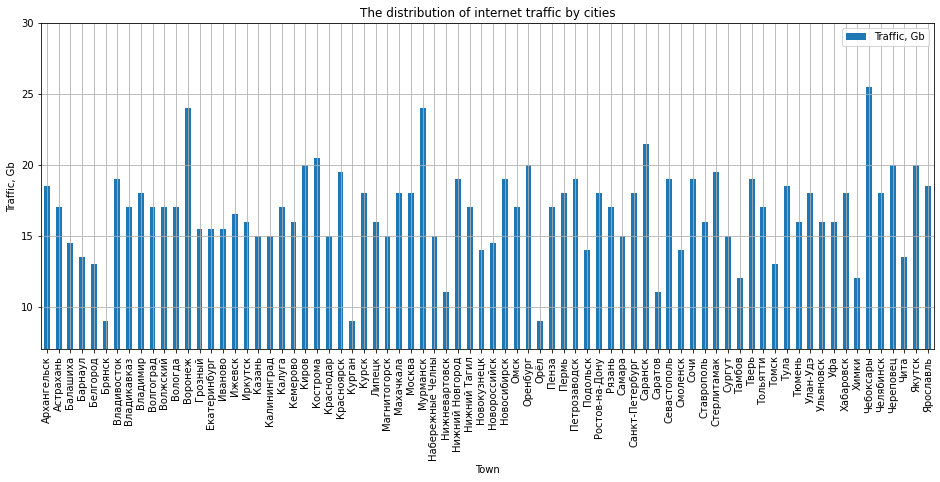

In [417]:
pivot_table_city_gb = df_users.pivot_table(index = 'city', 
                                           values = 'gigabyte', 
                                           aggfunc = ['mean', 'count', 'median']
                                           ).sort_values('city')

pivot_table_city_gb.columns = ['mean', 'count', 'median']

pivot_table_city_gb.plot(y = 'median', 
                         figsize=(16, 6), 
                         kind='bar', 
                         rot=90)
plt.title('The distribution of internet traffic by cities')
plt.ylabel('Traffic, Gb')
plt.xlabel('Town')
plt.legend(['Traffic, Gb'])
plt.ylim(7, 30)
plt.grid(True)

In [418]:
pivot_table_city_gb[pivot_table_city_gb['median']==pivot_table_city_gb['median'].max()]

,mean,count,median
city,,,
Чебоксары,22.7,20,25.5


In [419]:
pivot_table_city_gb[pivot_table_city_gb['median']==pivot_table_city_gb['median'].min()]

,mean,count,median
city,,,
Брянск,13.214286,28,9.0
Курган,8.894737,19,9.0
Орёл,12.960000,25,9.0


Conclusion: we can see that subscribers:
call more often in Kemerovo, less often in Cheboksary;
the largest number of minutes is used for calls in Kemerovo, the smallest in Cheboksary;
the largest number of SMS was sent to Surgut; the smallest to Orel;
the largest amount of internet traffic was spent in Cheboksary, the smallest in Bryansk, Kurgan and Orel.
In general, for subscribers - they talk more on the phone in Kemerovo, communicate more via SMS in Surgut, and the most active internet users in Cheboksary.

#### Revenue:

In [420]:
pivot_table_city_rev_smart = df_users.query('tariff == "smart"').pivot_table(index = 'city', 
                                                                             values = 'month_revenue', 
                                                                             aggfunc = ['mean', 'count', 'median']
                                                                             ).sort_values('city')
pivot_table_city_rev_smart.columns = ['mean', 'count', 'median']
pivot_table_city_rev_smart = pivot_table_city_rev_smart.reset_index()

pivot_table_city_rev_ultra = df_users.query('tariff == "ultra"').pivot_table(index = 'city', 
                                                                             values = 'month_revenue', 
                                                                             aggfunc = ['mean', 'count', 'median']
                                                                             ).sort_values('city')

pivot_table_city_rev_ultra.columns = ['mean', 'count', 'median']
pivot_table_city_rev_ultra = pivot_table_city_rev_ultra.reset_index()


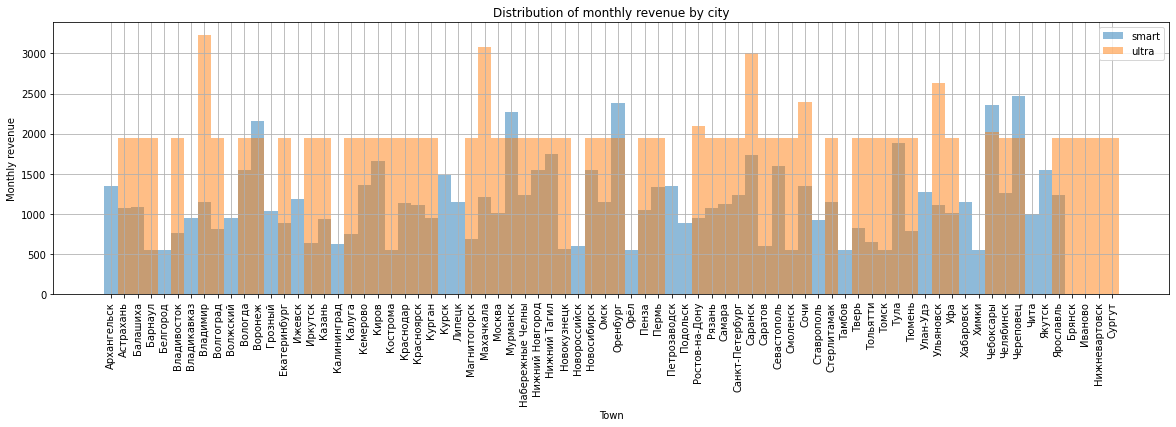

In [421]:
fig, ax = plt.subplots(figsize=(20, 5))

x1 = pivot_table_city_rev_smart['city']
y1 = pivot_table_city_rev_smart['median']

x2 = pivot_table_city_rev_ultra['city']
y2 = pivot_table_city_rev_ultra['median']

ax.bar(x1, y1, width = 1.0, alpha=0.5)
ax.bar(x2, y2, width = 1.0, alpha=0.5)

plt.legend(['smart', 'ultra'])
plt.xticks(rotation=90)
plt.title('Distribution of monthly revenue by city')
plt.ylabel('Monthly revenue')
plt.xlabel('Town')
plt.grid(True)
plt.show()

In [422]:
pivot_table_city_rev_smart[pivot_table_city_rev_smart['median'] == pivot_table_city_rev_smart['median'].max()]

,city,mean,count,median
68,Череповец,2162.454545,11,2468.0


In [423]:
pivot_table_city_rev_smart[pivot_table_city_rev_smart['median'] == pivot_table_city_rev_smart['median'].min()]

,city,mean,count,median
3,Барнаул,752.000000,7,550.0
4,Белгород,737.400000,15,550.0
21,Кострома,1003.111111,9,550.0
39,Орёл,1064.720000,25,550.0
51,Смоленск,593.222222,9,550.0
55,Тамбов,596.478261,23,550.0
58,Томск,919.347826,23,550.0
65,Химки,638.400000,5,550.0


In [424]:
pivot_table_city_rev_ultra[pivot_table_city_rev_ultra['median'] == pivot_table_city_rev_ultra['median'].max()]

,city,mean,count,median
5,Владимир,3225.0,2,3225.0


In [425]:
pivot_table_city_rev_ultra[pivot_table_city_rev_ultra['median'] == pivot_table_city_rev_ultra['median'].min()]

,city,mean,count,median
0,Астрахань,1950.000000,5,1950.0
1,Балашиха,1950.000000,10,1950.0
2,Барнаул,1950.000000,11,1950.0
3,Брянск,2030.357143,28,1950.0
4,Владивосток,1950.000000,11,1950.0
6,Волгоград,2335.714286,14,1950.0
7,Вологда,1950.000000,11,1950.0
8,Воронеж,2317.741935,31,1950.0
9,Екатеринбург,1950.000000,9,1950.0
10,Иваново,1950.000000,2,1950.0


Conclusion: We can see that the highest average monthly revenue comes from the city of Cherepovets for the Smart tariff, and from the city of Vladimir for the Ultra tariff. 

Furthermore, the minimum level of revenue corresponds to the subscription fee for each tariff respectively. 

From the graph, it is evident that Ultra subscribers mostly do not exceed the subscription fee, which cannot be said for Smart.

#### Annual revenue:

Annual revenue: 4914451.0


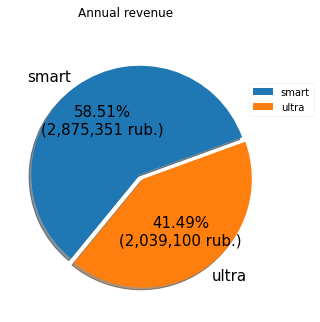

In [426]:
all_revenue = df_users['month_revenue'].sum()
print('Annual revenue:',all_revenue)


def func_pct(pct):
    value = float(pct/100.*all_revenue)
    return "{:.2f}%\n({:,.0f} rub.)".format(pct, value)

explode = (0.05, 0)

axes = df_users.groupby('tariff')['month_revenue'].sum().plot(kind='pie', 
                                                              subplots=True, 
                                                              fontsize=15,
                                                              use_index=False, 
                                                              shadow=True, 
                                                              explode=explode,
                                                              title = 'Annual revenue',
                                                              startangle=20, 
                                                              figsize=(20,5),
                                                              autopct=lambda pct: func_pct(pct))

for ax in axes:
    ax.legend(['smart', 'ultra'], 
              bbox_to_anchor=(0.87,0.87), 
              framealpha=0.2, 
              prop={'size':10})
    ax.set_ylabel('')

In [427]:
print('On average, the subscriber brings in revenue per year:',(all_revenue/users['tariff'].value_counts()).round())


On average, the subscriber brings in revenue per year: smart    14001.0
ultra    32983.0
Name: tariff, dtype: float64


From the distribution of annual revenue, we can see that the largest amount of annual revenue, 59%, is brought by smart subscribers, rather than ultra, but at the same time the smart revenue outweighs the number of subscribers. At the same time, on average, each smart user brings 14001 rubles to the operator per year, and ultra 32983 rubles, 2.35 times more than smart.

### Based on the data analysis, we can see:
* Consumption of minutes, SMS, and GB by Ultra tariff subscribers is higher than that of Smart subscribers;
* The dispersion of Ultra tariff is higher than Smart, which may indicate that Smart subscribers limit themselves;
* On average, subscribers spend 282-589 minutes on phone calls, but 443 minutes on average;
* On average, subscribers send 9-57 SMS, but 30 SMS on average;
* On average, subscribers spend 13-21 GB of internet traffic, but 17 GB on average;
* On average, subscribers pay 750-1950 rubles per month for the tariffs, but 1654 rubles on average;
* On average, subscribers overpay up to 938 rubles per month, but 164 rubles on average;
* Smart subscribers mostly use tariff packages, but they do not have enough monthly internet traffic volume, so they have to buy more;
* Ultra subscribers mostly use internet packages, but tariff minutes and SMS are used on average only 18.6% and 5.7%, respectively;
* On average, all subscribers tend to increase the consumption of minutes, SMS, and MB by the end of the year;
* In general, subscribers in Kemerovo talk more on the phone, in Surgut they communicate more via SMS, and the most active internet users are in Cheboksary;
* The highest average monthly revenue from Smart tariff comes from Cherepovets;
* The highest average monthly revenue from Ultra tariff comes from Vladimir;
* Ultra subscribers, on average, do not overpay the subscription fee;
* Smart and Ultra subscribers bring annual revenue in the ratio of 58% and 42% of the total volume;
* Smart subscribers form 58% of the annual revenue in quantitative terms;
* Ultra subscribers form 2.35 times more annual revenue in qualitative terms than Smart subscribers.

## 4. Hypothesis Testing.

### Hypothesis: The average revenue of users of the "Ultra" and "Smart" tariffs differs.

We form hypotheses:

H0 — The average revenue of users of the "Ultra" and "Smart" tariffs is equal

H1 — The average revenue of users of the "Ultra" and "Smart" tariffs differs

The critical level of statistical significance is 5%, it can be lower but there is a risk of rejecting a working hypothesis.

In [428]:
tariff_smart = df_users.query('tariff == "smart"')
tariff_smart.head()

,user_id,month,calls,duration,num_messages,mb,tariff,city,gigabyte,monthly_fee,min_over_lim,sms_over_lim,gb_over_lim,pay_over_lim,month_revenue
8,1001,11,59.0,430.0,0.0,18429.34,smart,Москва,18.0,550.0,0.0,0.0,3.0,600.0,1150.0
9,1001,12,63.0,414.0,0.0,14036.66,smart,Москва,14.0,550.0,0.0,0.0,0.0,0.0,550.0
10,1002,6,15.0,117.0,4.0,10856.82,smart,Стерлитамак,11.0,550.0,0.0,0.0,0.0,0.0,550.0
11,1002,7,26.0,214.0,11.0,17580.10,smart,Стерлитамак,18.0,550.0,0.0,0.0,3.0,600.0,1150.0
12,1002,8,42.0,289.0,13.0,20319.26,smart,Стерлитамак,20.0,550.0,0.0,0.0,5.0,1000.0,1550.0


In [429]:
tariff_ultra = df_users.query('tariff == "ultra"')
#tariff_ultra.head()

In [430]:
alpha = 0.05 
results = st.ttest_ind(
    tariff_smart['month_revenue'], 
    tariff_ultra['month_revenue'])

print('p-value:', results.pvalue)

if (results.pvalue < alpha):
    print('We reject the null hypothesis')
else:
    print('We were unable to reject the null hypothesis')

p-value: 1.4229814360764067e-160
We reject the null hypothesis


Conclusion: The probability being very close to zero tells us that the hypothesis H0 has not been confirmed, and the average revenue of users of the Smart and Ultra tariffs does indeed differ.

### Hypothesis: The average revenue of users from Moscow differs from the revenue of users from other regions.

H0 — the average revenue of users from Moscow is equal to the average revenue of users from other regions.

H1 — the average revenue of users from Moscow differs from the average revenue of users from other regions.

Critical level of statistical significance 5%.

In [431]:
moscow = df_users.query('city == "Москва"')['month_revenue']
regions = df_users.query('city != "Москва"')['month_revenue']

In [432]:
alpha = 0.05 
results = st.ttest_ind(moscow, regions)

print('p-value:', results.pvalue)

if (results.pvalue < alpha):
    print('We reject the null hypothesis')
else:
    print('We were unable to reject the null hypothesis')

p-value: 0.5440152911670224
We were unable to reject the null hypothesis


Conclusion: The probability is 54.4% - the null hypothesis cannot be rejected. This means that the average revenue from Moscow does not differ from the revenue from other regions.

In [433]:
tariff_consumption

,tariff,duration,dev_duration,dev_duration_perc,num_messages,dev_sms,dev_sms_perc,gigabyte,dev_gb,dev_gb_perc,monthly_fee,month_revenue,overpayment,overpayment_perc
0,smart,437.0,-63.0,87.4,34.0,-16.0,68.0,17.0,2.0,113.3,550,1304.0,754.0,137.1
1,ultra,558.0,-2442.0,18.6,57.0,-943.0,5.7,20.0,-10.0,66.7,1950,2061.0,111.0,5.7


## 5. Overall conclusion: 

Based on the intermediate results and conclusions of the data analysis, it can be said that: 
* The dataframes obtained for analysis almost did not require preliminary preparation. Data preparation included transforming column formats, rounding data to tariff conditions, deleting erroneous columns, calculating and entering additional fields into the dataframe necessary for further analysis; 
* It was found that there are 2.35 times more users of the smart tariff than of the ultra tariff, which is explained by more favorable conditions; 
* During the merging of dataframes into a single table, a non-critical decrease in the number of subscribers by 0.4% was revealed due to inaccurate data extraction for calls, SMS and internet traffic.

Based on the data analysis and hypothesis testing, we can see:
* Consumption of minutes, SMS, and GB by Ultra tariff subscribers is higher than that of Smart subscribers;
* The variance of Ultra tariff is higher than Smart tariff, which may indicate that Smart subscribers are limiting themselves;
* On average, subscribers spend 282-589 minutes on phone calls, but 443 minutes on average;
* On average, subscribers send 9-57 SMS, but 30 SMS on average;
* On average, subscribers use 13-21 GB of internet traffic, but 17 GB on average;
* On average, subscribers pay 750-1950 rubles per month for the tariffs, but 1654 rubles on average;
* On average, subscribers overpay up to 938 rubles per month, but 164 rubles on average;
* Smart subscribers mostly use tariff packages, but they do not have enough monthly internet traffic volume, so they have to buy more;
* Ultra subscribers mostly use internet packages, but tariff minutes and SMS are used on average only 18.6% and 5.7%, respectively;
* On average, all subscribers tend to increase the consumption of minutes, SMS, and MB by the end of the year;
* In general, subscribers in Kemerovo talk more on the phone, in Surgut they communicate more via SMS, and the most active internet users are in Cheboksary;
* The highest average monthly revenue from Smart tariff comes from Cherepovets;
* The highest average monthly revenue from Ultra tariff comes from Vladimir;
* Ultra subscribers, on average, do not overpay the subscription fee, they overpay 5.7% of the subscription fee on average, while Smart subscribers overpay 137.1%;
* Subscribers on the Ultra tariff generally do not overpay the subscription fee, on average Ultra overpays by 5.7% of the subscription fee, while Smart overpays by 137.1%;
* Subscribers of Smart and Ultra bring annual revenue in the ratio of 58% and 42% of the total volume;
* They form an annual revenue in quantitative terms more than Smart subscribers 58%;
* On average, a Smart subscriber brings 14,001 rubles to the operator per year, and an Ultra subscriber brings 32,983 rubles;
* Subscribers of Ultra form an annual revenue in qualitative terms more than Smart, 2.35 times more;
* Average revenues from users in Moscow do not differ from revenues in other settlements.

## According to the results of the statistical analysis, Ultra tariff is the most beneficial for the operator.


